# 1. Regular-Scale Model Specification
$$ %
\newcommand{\der}[2][]{\frac{\mathrm{d}^{#1}}{\mathrm{d} {#2}^{#1}}}
$$

In [1]:
# Jax related libraries
import jax.scipy as jsp
import jax.numpy as jnp
import numdifftools as nd
from kalmanODE_jax import *
from jax.config import config
from jax import grad, jit, partial
config.update("jax_enable_x64", True)

# Other libraries
import numpy as np
import scipy as sp
from rodeo.ibm import ibm_init
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_blas
from scipy.integrate import odeint
from lotka import lotka as inference

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Save to csv
import pandas as pd

The Lotka-Volterra model is given by
\begin{equation*}
    \begin{aligned}
      \der t H_t & = \alpha H_t - \beta H_tL_t \\
      \der t L_t & = -\gamma L_t + \delta H_tL_t,
    \end{aligned}
  \end{equation*}
  
We first solve the ODE with rodeo and compare it with the solution given by `odeint()` for a sanity check.

In [2]:
def lotka(X_t, t, theta):
    "Lotka-Volterra ODE Model"
    alpha, beta, gamma, delta = theta
    p = len(X_t)//2
    H, L = X_t[0], X_t[p]
    return jnp.stack([alpha*H - beta*H*L,
                      -gamma*L + delta*H*L])

Define the necessary parameters for the rodeo ODE solver.

In [3]:
# Define the IVP
W = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]]) # LHS vector of ODE
x0 = np.array([5, -10, 3, 3]) # initial value for the IVP

# Parameters of the ODE
theta = np.array([1, 1, 4, 1]) # True theta

# Time interval on which a solution is sought.
tmin = 0 
tmax = 2.1

# Define the prior process
n_deriv = [1, 1] # number of derivatives in IVP
n_obs = 2 # number of observations
n_deriv_prior = [3, 3] # number of derivatives in IBM prior
p = sum(n_deriv_prior)
state_ind = [0, 3] # Index of each observation

# Pad the inputs
x0 = zero_pad(x0, n_deriv, n_deriv_prior)
W = zero_pad(W, n_deriv, n_deriv_prior)

# IBM process scale factor
scale = [.1]*2

# Choose small enough step size for good approximation
h = 0.01
n_eval = int((tmax-tmin)/h)

# Instantiate the ODE solver object.
# generate the Kalman parameters corresponding to the prior
prior = ibm_init(h, n_deriv_prior, scale)
prior = indep_init(prior, n_deriv_prior)

# Evaluate the ODE solution
ksim_jax = \
    solve_sim(lotka, x0, tmin, tmax, n_eval, W, **prior, theta=theta)

Now we check if the solution is a good approximation by comparing it to the solution from the built-in ODE solver, `odeint()`.

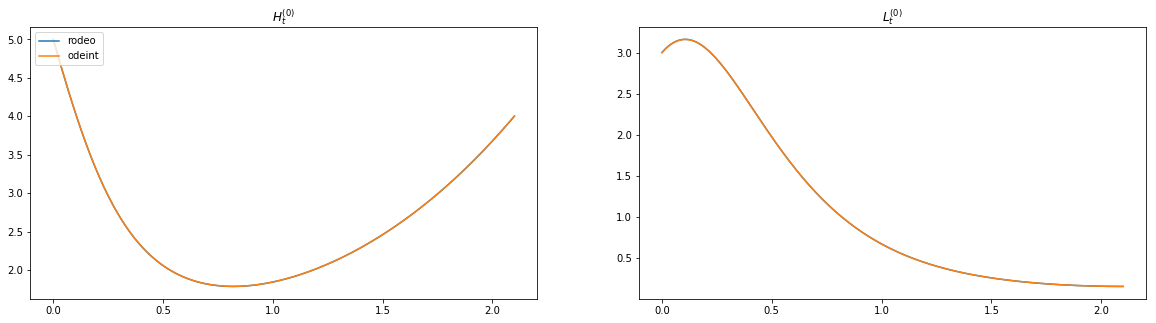

In [4]:
tseq = np.linspace(tmin, tmax, n_eval+1) # Evaluation points
ode = odeint(lotka, x0[state_ind], tseq, args=(theta,))

# Plot the two solutions
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, ksim_jax[:,0], label='rodeo')
axs[0].plot(tseq, ode[:,0], label='odeint')
axs[0].set_title("$H^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, ksim_jax[:,3], label='rodeo')
axs[1].plot(tseq, ode[:,1], label='odeint')
axs[1].set_title("$L^{(0)}_t$")
plt.show()

## 1.1 Timing

We perform a speed test comparing the jax version of rodeo to the Cython/BLAS version of rodeo.

In [5]:
def lotka2(X_t, t, theta, out=None):
    "Lotka-Volterra ODE Model with in-place updates"
    if out is None:
        out = np.empty(2)
    alpha, beta, gamma, delta = theta
    p = len(X_t)//2
    H, L = X_t[0], X_t[p]
    out[0] = alpha*H - beta*H*L
    out[1] = -gamma*L + delta*H*L
    return out

In [21]:
%timeit -o _ = \
    solve_sim(lotka, x0, tmin, tmax, n_eval, W, \
              **prior, theta=theta).block_until_ready()

499 µs ± 25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 499 µs ± 25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [22]:
kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, lotka2, **prior)
%timeit -o _ = kalmanode.solve_sim(x0, W, theta)

1.22 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 1.22 ms ± 41.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [23]:
%timeit -o _ = odeint(lotka, x0[state_ind], tseq, args=(theta,))

50.9 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 50.9 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

## 1.2 Generate Observations

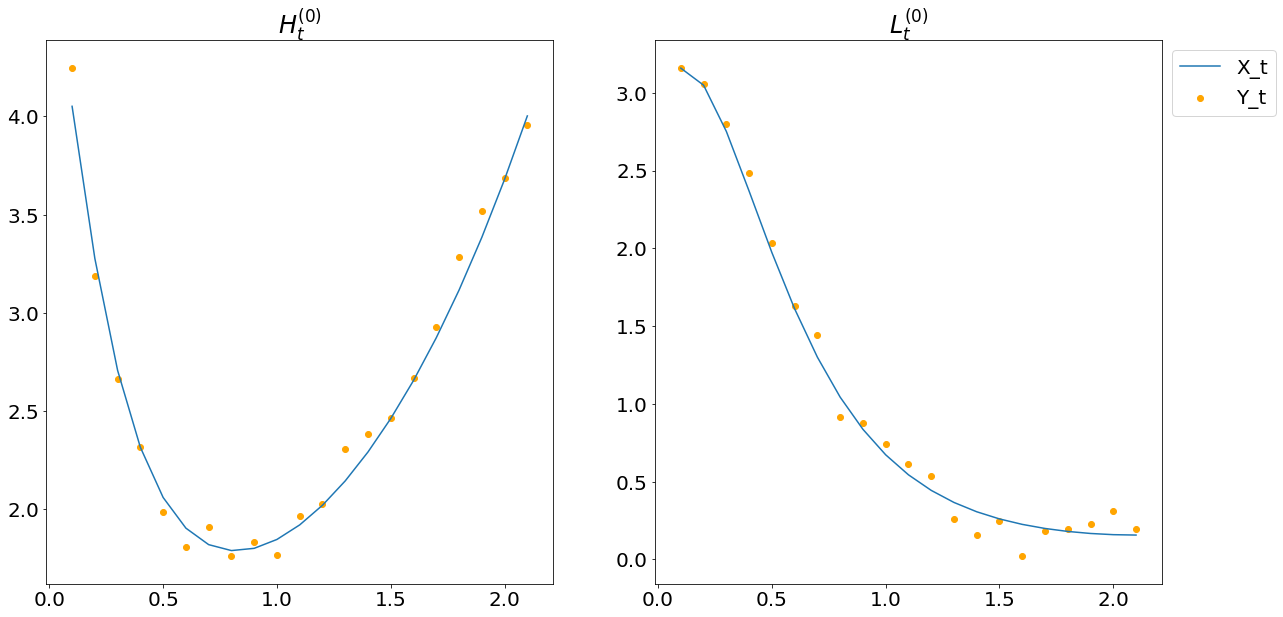

In [25]:
# logprior parameters
theta_true = jnp.array([1, 1, 4, 1]) # True theta
n_theta = len(theta_true)
phi_true = jnp.log(theta_true) # Convert theta on the log scale
phi_sd = 4.6*jnp.ones(n_theta) # Assuming prior is lognormal on true theta

# Observation noise
sigma = 0.1
#sigma = 0.1

# Number of samples to draw from posterior
n_samples = 10000

# Observations
deltat = 0.1 # Step size
n_obs = int((tmax-tmin)/deltat) + 1 # Number of observations
tseq = np.linspace(tmin, tmax, n_obs) # Discretization points


# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, n_eval, lotka, W)
Y_t, X_t = inf.simulate(x0[state_ind], phi_true, sigma, tseq)

# Use observations from 1 onwards
tseq = tseq[1:]

# Plot observations against exact solution
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(tseq, X_t[:,0], label = 'X_t')
axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$H^{(0)}_t$")
axs[1].plot(tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$L^{(0)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])

## 1.3 Parameter Inference

Standard parameter inference with both components and known noise parameter $\sigma$.

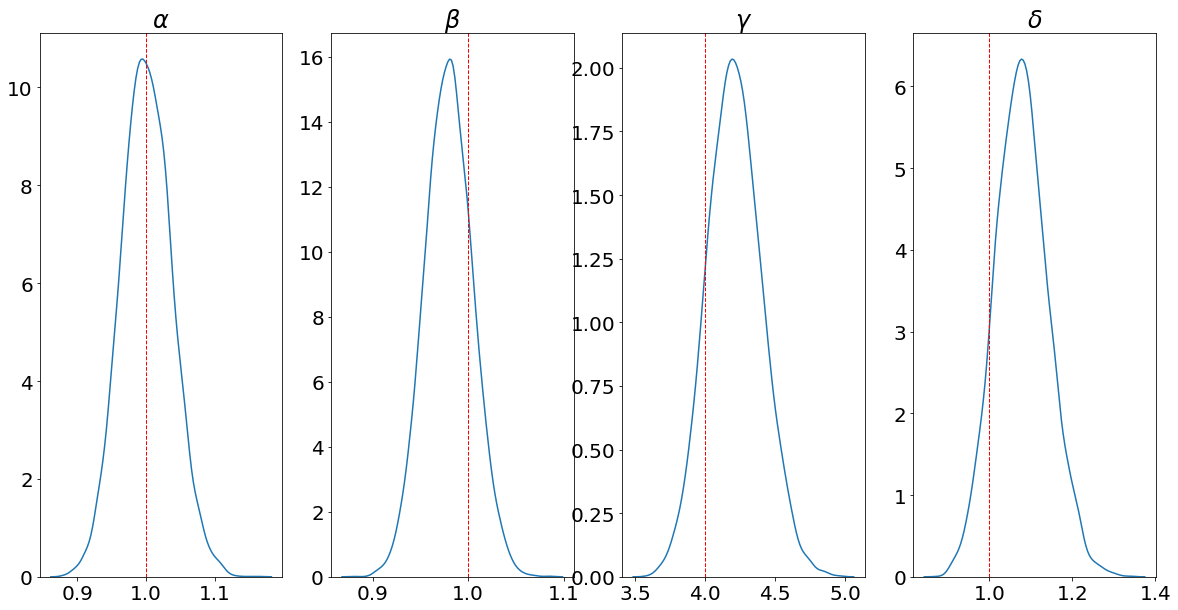

In [26]:
# Parameter inference
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, [sigma])
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples) # Sample for the posterior

# Plot posterior
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
inf.theta_plot(kalman_phi, phi_true, var_names)

Now we assume the noise parameter $\sigma$ is unknown and we try to estimate it.

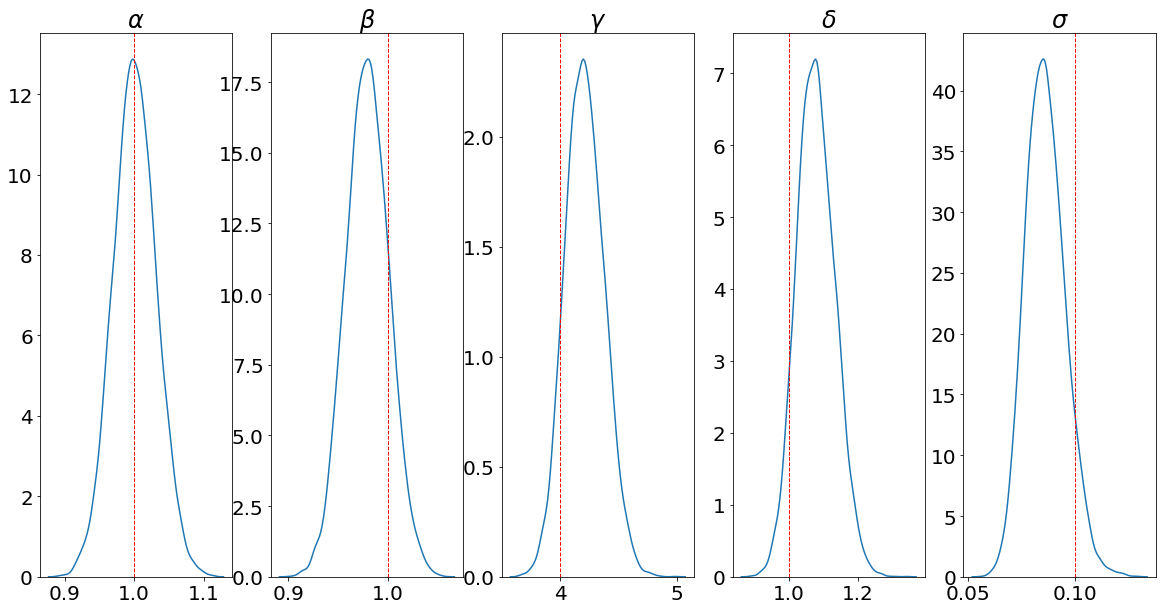

In [27]:
# Parameter inference
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, sigma=[None])
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
param_true = jnp.append(phi_true, np.log(sigma))
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", r"$\sigma$"]
inf.theta_plot(kalman_phi, param_true, var_names)

### 1.3.1 Using only $L_t$

Now we assume we only have access to the second component of the observations, that is $L_t$ from $(H_t, L_t)$.

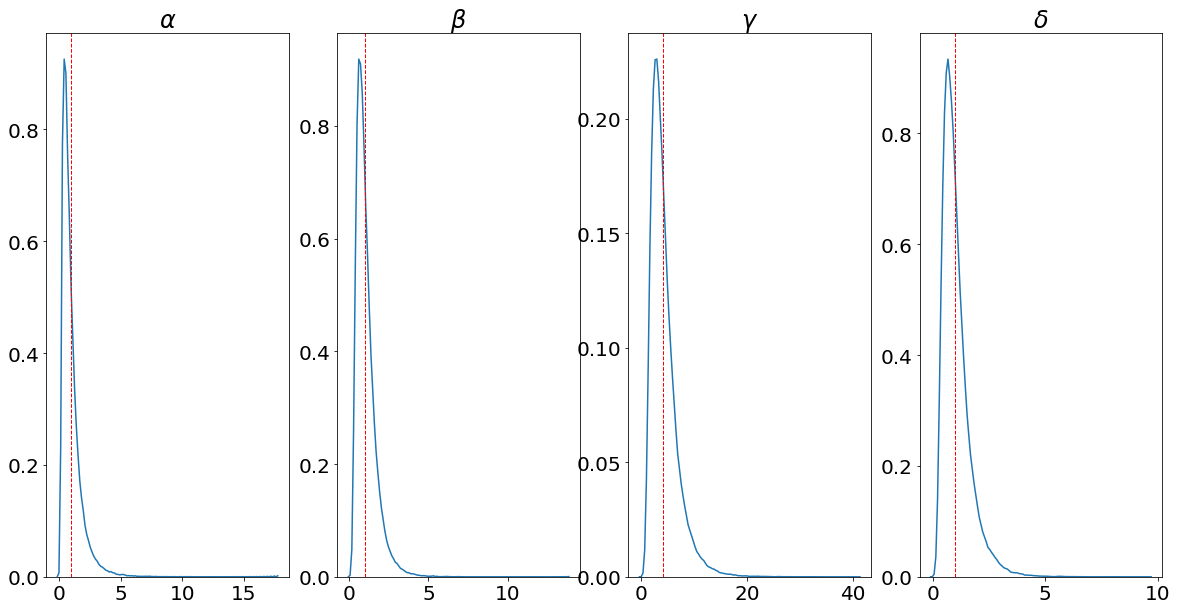

In [8]:
# Parameter inference
Y_t = Y_t[:, 1] # Use second component only
inf.state_ind = 3 # Update observation index
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, [sigma])
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
inf.theta_plot(kalman_phi, phi_true, var_names)

Again we assume $\sigma$ is unknown and try to estimate it.

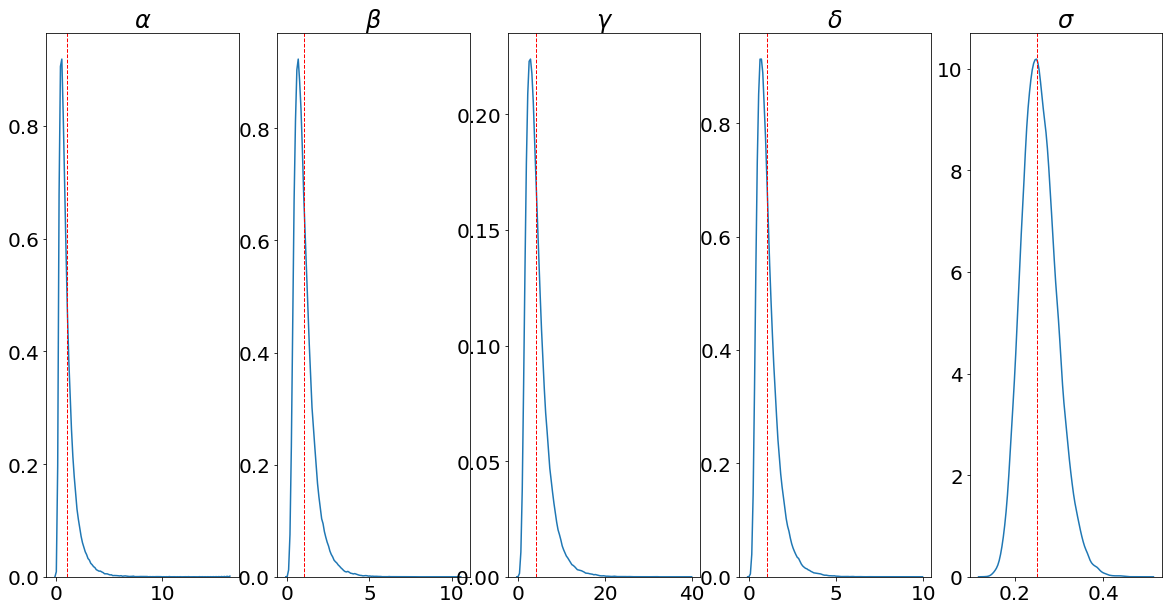

In [9]:
# Parameter inference
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior)
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
param_true = jnp.append(phi_true, np.log(sigma))
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", r"$\sigma$"]
inf.theta_plot(kalman_phi, param_true, var_names)

# 2. Log-Scale Model Specifications

So far we've done all parameter inferences on the regular scale. We have seen from past experiments, that log-scale works better in another SDE method. So we will try it here. First we redefine the ODE on the log-scale

\begin{equation*}
    \begin{aligned}
      \der t \log H_t & = \alpha - \beta L_t \\
      \der t \log L_t & = -\gamma + \delta H_t,
    \end{aligned}
  \end{equation*}
 
where we used the fact that $\der t \log X_t = \frac{1}{X_t} \der t X_t$
We first solve the ODE with rodeo and compare it with the solution given by `odeint()` for a sanity check.

In [2]:
from math import exp, log
def loglotka(Z_t, t, theta):
    "Lotka-Volterra ODE Model"
    alpha, beta, gamma, delta = theta
    p = len(Z_t)//2
    Z_t = jnp.exp(Z_t)
    H, L = Z_t[0], Z_t[p]
    return jnp.stack([alpha - beta*L,
                      -gamma + delta*H])

In [3]:
# Define the IVP
W = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]]) # LHS vector of ODE
x0 = np.array([log(5), -2, log(3), 1]) # initial value for the IVP

# Time interval on which a solution is sought.
tmin = 0 
tmax = 2.1

# Define the prior process
n_deriv = [1, 1] # number of derivatives in IVP
n_obs = 2 # number of observations
n_deriv_prior = [3, 3] # number of derivatives in IBM prior
p = sum(n_deriv_prior)
state_ind = [0, 3] # Index of each observation

# Pad the inputs
x0 = zero_pad(x0, n_deriv, n_deriv_prior)
W = zero_pad(W, n_deriv, n_deriv_prior)

# IBM process scale factor
scale = [.1]*2

# Choose small enough step size for good approximation
h = 0.1
n_eval = int((tmax-tmin)/h)

# Instantiate the ODE solver object.
# generate the Kalman parameters corresponding to the prior
prior = ibm_init(h, n_deriv_prior, scale)
prior = indep_init(prior, n_deriv_prior)

# Parameters of the ODE
theta = np.array([1, 1, 4, 1]) # True theta

# Evaluate the ODE solution
ksim_jax = \
    np.exp(solve_sim(loglotka, x0, tmin, tmax, n_eval, W, **prior, theta=theta))

We took the exponent to return to the regular scale as a comparison to the plot in the previous section

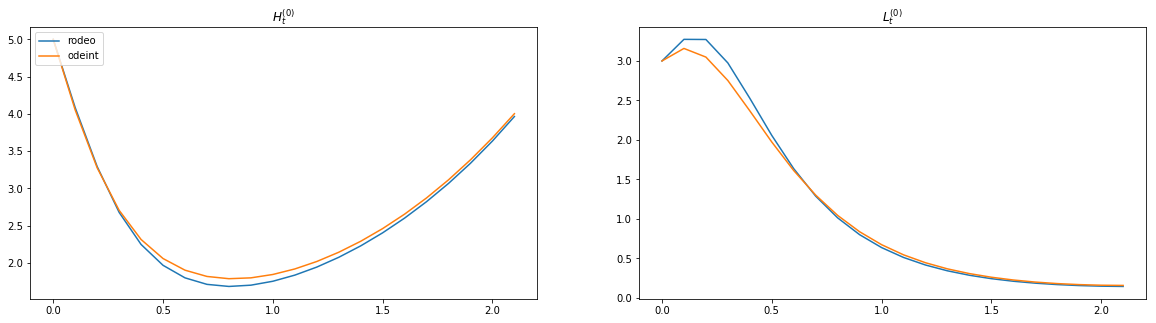

In [4]:
tseq = np.linspace(tmin, tmax, n_eval+1) # Evaluation points
ode = np.exp(odeint(loglotka, x0[state_ind], tseq, args=(theta,)))

# Plot the two solutions
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, ksim_jax[:,0], label='rodeo')
axs[0].plot(tseq, ode[:,0], label='odeint')
axs[0].set_title("$H^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, ksim_jax[:,3], label='rodeo')
axs[1].plot(tseq, ode[:,1], label='odeint')
axs[1].set_title("$L^{(0)}_t$")
plt.show()

## 2.1 Timing

We perform a speed test comparing the jax version of rodeo to the Cython/BLAS version of rodeo.

In [5]:
def loglotka2(Z_t, t, theta, out=None):
    "Lotka-Volterra ODE Model with in-place updates"
    if out is None:
        out = np.empty(2)
    alpha, beta, gamma, delta = theta
    p = len(Z_t)//2
    Z_t = np.exp(Z_t)
    H, L = Z_t[0], Z_t[p]
    out[0] = alpha - beta*L
    out[1] = -gamma + delta*H
    return out

In [27]:
%timeit -o _ = \
    solve_sim(loglotka, x0, tmin, tmax, n_eval, W, \
              **prior, theta=theta).block_until_ready()

159 µs ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<TimeitResult : 159 µs ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)>

In [28]:
kalmanode = KalmanODE_blas(W, tmin, tmax, n_eval, loglotka2, **prior)
%timeit -o _ = kalmanode.solve_sim(x0, W, theta)

520 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 520 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [29]:
%timeit -o _ = odeint(loglotka, x0[state_ind], tseq, args=(theta,))

464 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 464 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [6]:
lv_high = pd.read_csv("lv_data_high.csv")
lv_low = pd.read_csv("lv_data_low.csv")
lv_high = lv_high.iloc[:, 3:5]
lv_low = lv_low.iloc[:, 3:5]

## 2.2 Generate Observations

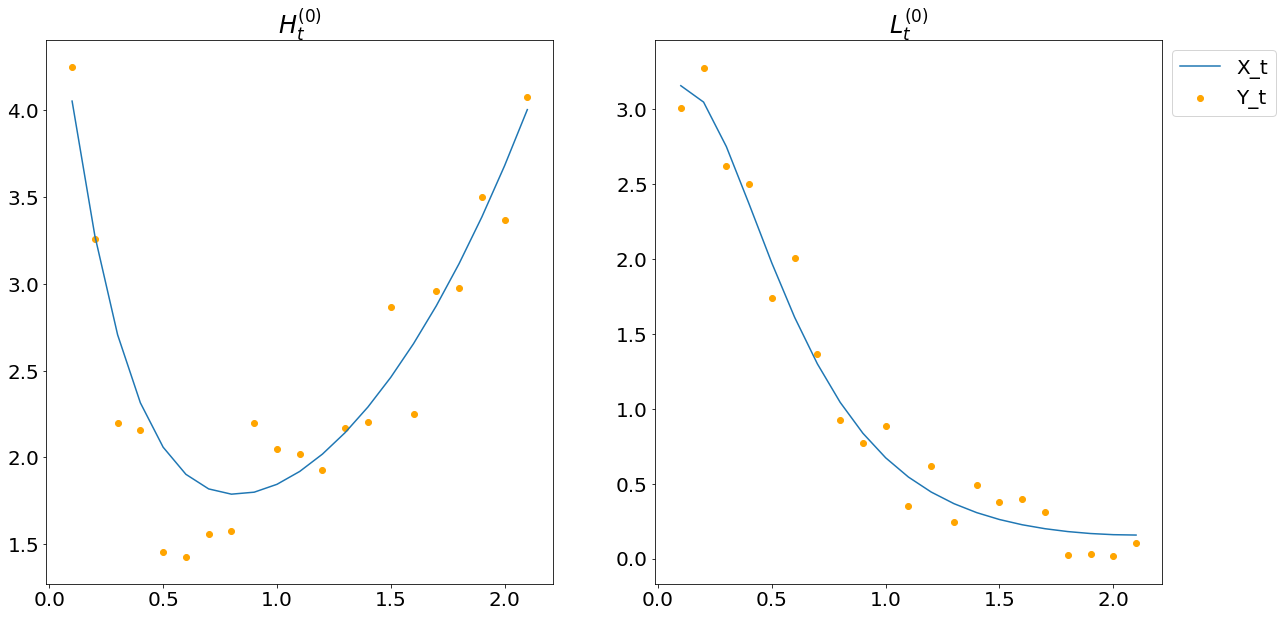

In [5]:
# logprior parameters
theta_true = jnp.array([1, 1, 4, 1]) # True theta
phi_true = jnp.log(theta_true) # Convert theta on the log scale
n_theta = len(phi_true)
phi_sd = 4.6*jnp.ones(n_theta)

# Observation noise
sigma = 0.25
#sigma = 0.1

# Number of samples to draw from posterior
n_samples = 10000

# Observations
deltat = 0.1 # Step size
n_obs = int((tmax-tmin)/deltat) + 1 # Number of observations
tseq = np.linspace(tmin, tmax, n_obs) # Discretization points


# Initialize inference class and simulate observed data
inf = inference(state_ind, tmin, tmax, n_eval, loglotka, W)
# Returned solution is already converted to regular-scale
Y_t, X_t = inf.simulate(x0[state_ind], phi_true, sigma, tseq, log=True) 

# Use observations from 1 onwards
tseq = tseq[1:]

# Plot observations against exact solution
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].plot(tseq, X_t[:,0], label = 'X_t')
axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
axs[0].set_title("$H^{(0)}_t$")
axs[1].plot(tseq, X_t[:,1], label = 'X_t')
axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
axs[1].set_title("$L^{(0)}_t$")
axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])

In [8]:
Y_t = np.array(lv_high)

## 2.3 Parameter Inference

Standard parameter inference with both components and known noise parameter $\sigma$.

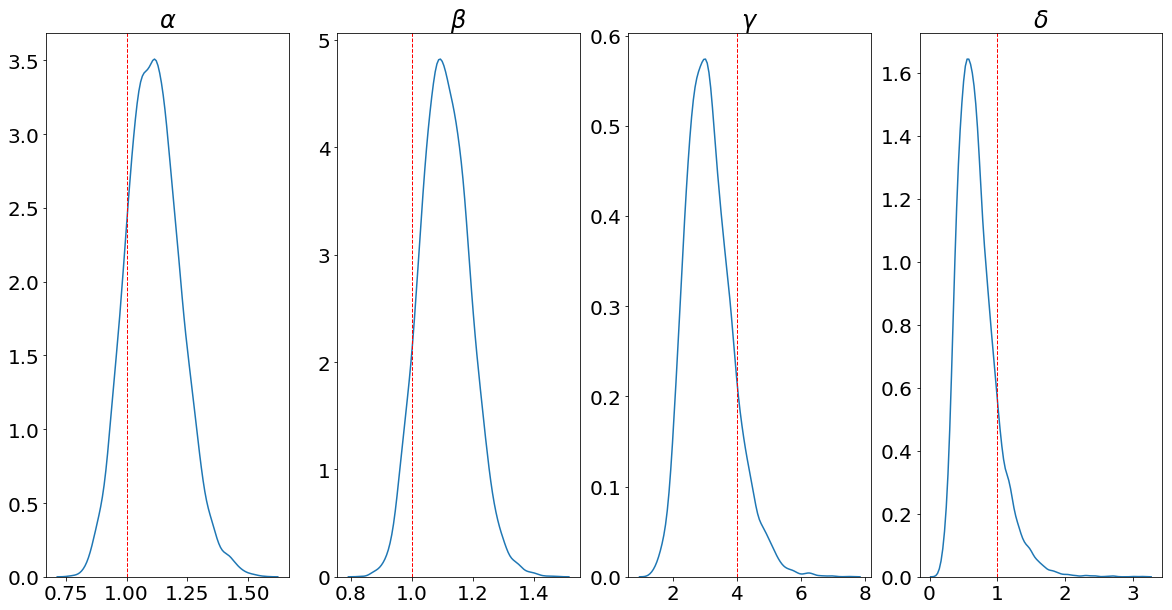

In [6]:
# Parameter inference
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, [sigma], log=True)
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples) # Sample for the posterior

# Plot posterior
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
col_names = [s.strip(r"$\\") for s in var_names]
#pd.DataFrame(kalman_phi, columns = col_names).to_csv("highnoise_knownnoise_knownprey.csv")
inf.theta_plot(kalman_phi, phi_true, var_names)

Now we assume the noise parameter $\sigma$ is unknown and we try to estimate it.

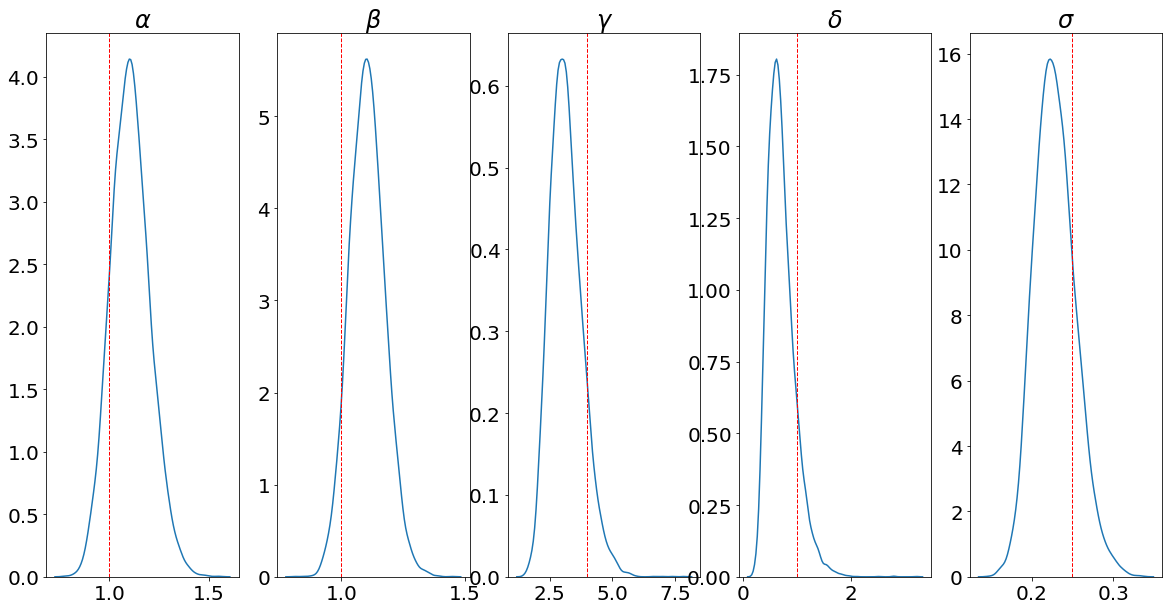

In [7]:
# Parameter inference
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, log=True)
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
param_true = jnp.append(phi_true, np.log(sigma))
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", r"$\sigma$"]
col_names = [s.strip(r"$\\") for s in var_names]
#pd.DataFrame(kalman_phi, columns = col_names).to_csv("highnoise_unknownnoise_knownprey.csv")
inf.theta_plot(kalman_phi, param_true, var_names)

### 2.3.1 Using only $L_t$

Now we assume we only have access to the second component of the observations, that is $L_t$ from $(H_t, L_t)$.

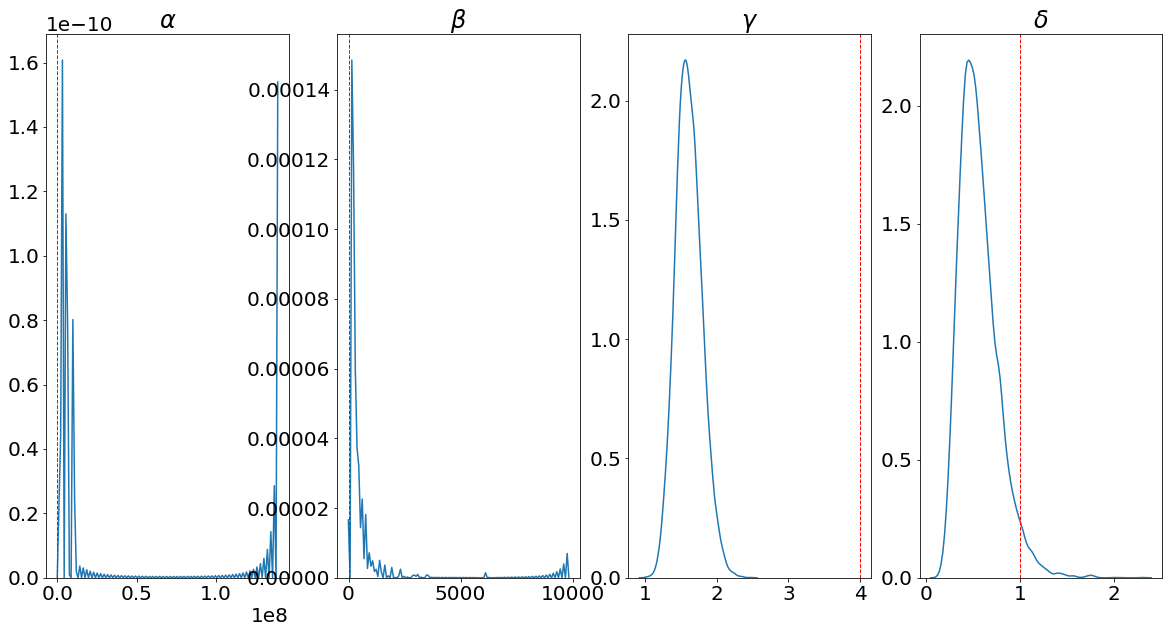

In [11]:
# Parameter inference
Y_t = Y_t[:, 1] # Use second component only
inf.state_ind = 3 # Update observation index
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, [sigma], log=True)
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$"]
col_names = [s.strip(r"$\\") for s in var_names]
#pd.DataFrame(kalman_phi, columns = col_names).to_csv("highnoise_knownnoise_unknownprey.csv")
inf.theta_plot(kalman_phi, phi_true, var_names)

Again we assume $\sigma$ is unknown and try to estimate it.

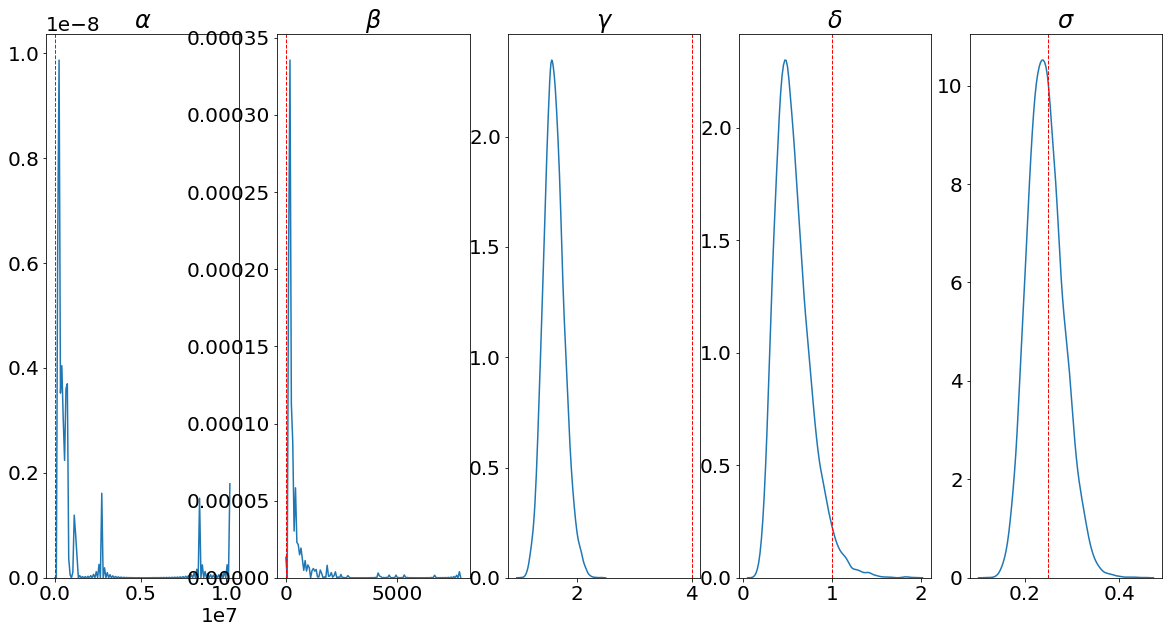

In [35]:
# Parameter inference
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, log=True)
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
param_true = jnp.append(phi_true, np.log(sigma))
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", r"$\sigma$"]
col_names = [s.strip(r"$\\") for s in var_names]
pd.DataFrame(kalman_phi, columns = col_names).to_csv("highnoise_unknownnoise_unknownprey.csv")
inf.theta_plot(kalman_phi, param_true, var_names)

Assuming that the initial value $X_0$ is unknown.

In [13]:
def loglotkaf(Z_t, t, theta):
    "Lotka-Volterra ODE Model"
    alpha, beta, gamma, delta = theta
    p = len(Z_t)//2
    X_t = jnp.exp(Z_t)
    H, L = X_t[0], X_t[p]
    return jnp.stack([Z_t[0], alpha - beta*L, 0,
                      Z_t[p], -gamma + delta*H, 0])

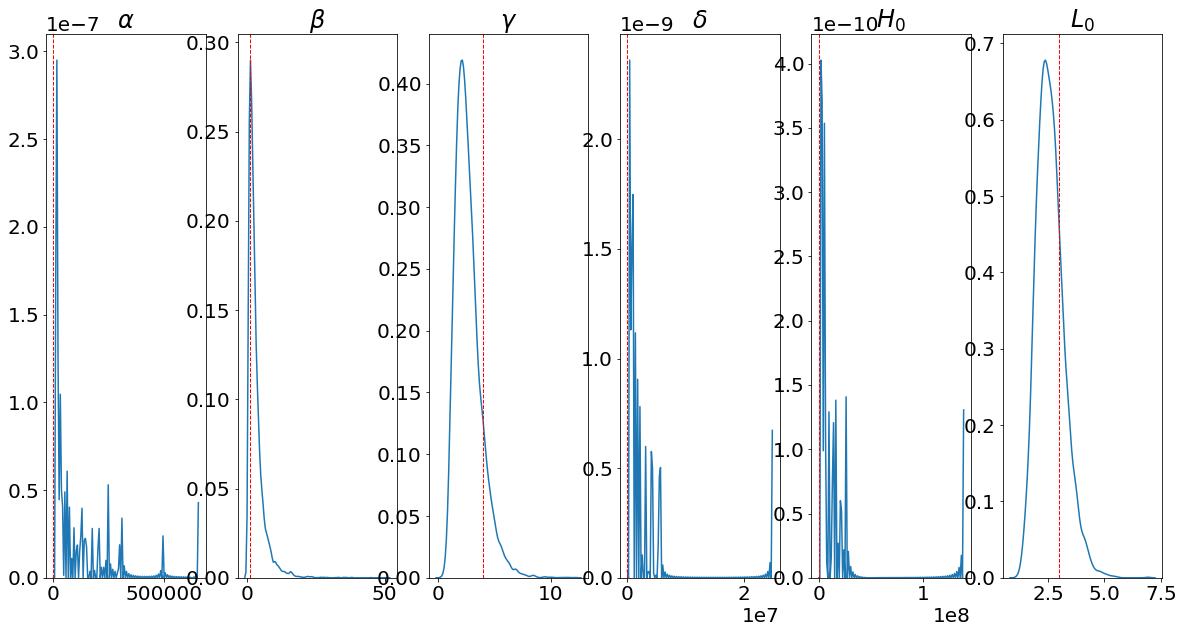

In [14]:
x0 = [None, None]
inf.funpad = loglotkaf
Y_t = Y_t[:, 1] # Use second component only
inf.state_ind = 3 # Update observation index
phi_hat, phi_var = inf.phi_fit(Y_t, x0, deltat, h, phi_true, phi_sd, prior, [sigma], log=True)
kalman_phi = inf.theta_sample(phi_hat, phi_var, n_samples)

# Plot posterior
param_true = jnp.append(phi_true, np.array([log(5), log(3)]))
var_names = [r"$\alpha$", r"$\beta$", r"$\gamma$", r"$\delta$", r"$H_0$", r"$L_0$"]
inf.theta_plot(kalman_phi, param_true, var_names)

### 2.3.2 Plotting Estimated Solutions

Using the $\theta$ from the parameter inference, we can plot a ribbon plot of the solution $(H_t, L_t)$.

In [38]:
samp_theta = jnp.exp(kalman_phi)
samp_len = len(samp_theta)
samp_Xt = np.zeros((2, samp_len, n_eval+1))
for i in range(samp_len):
    x0 = loglotkaf(jnp.log(samp_theta[i, 4:6]), 0, samp_theta[i, 0:4])
    sol = solve_sim(loglotka, x0, tmin, tmax, n_eval, W, **prior, theta=samp_theta[i, 0:4])
    samp_Xt[0, i] = np.exp(sol[:, 0])
    samp_Xt[1, i] = np.exp(sol[:, 3])

samp_upper = np.quantile(samp_Xt, 0.975, axis=1)
samp_lower = np.quantile(samp_Xt, 0.025, axis=1)
samp_mean = np.quantile(samp_Xt, 0.5, axis=1)

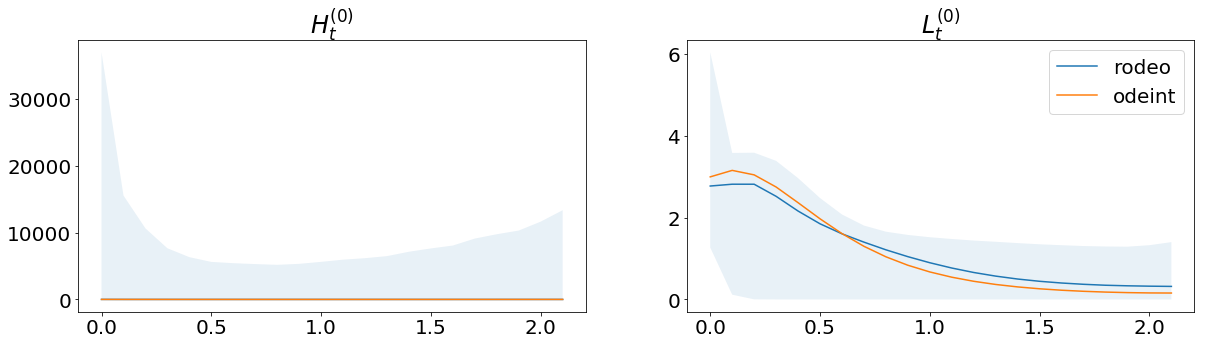

In [39]:
tseq = np.linspace(tmin, tmax, n_eval+1) # Evaluation points
ode = np.exp(odeint(loglotka, [log(5), log(3)], tseq, args=(theta,)))

# Plot the two solutions
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, samp_mean[0], label='rodeo')
#axs[0].plot(tseq, samp_upper[0], label='upper')
#axs[0].plot(tseq, samp_lower[0], label='lower')
axs[0].fill_between(tseq, samp_upper[0], samp_lower[0], alpha=0.1)
axs[0].plot(tseq, ode[:,0], label='true')
axs[0].set_title("$H^{(0)}_t$")

axs[1].plot(tseq, samp_mean[1], label='rodeo')
#axs[1].plot(tseq, samp_upper[1], label='upper')
#axs[1].plot(tseq, samp_lower[1], label='lower')
axs[1].fill_between(tseq, samp_upper[1], samp_lower[1], alpha=0.1)
axs[1].plot(tseq, ode[:,1], label='odeint')
axs[1].set_title("$L^{(0)}_t$")
axs[1].legend(loc='upper right')
plt.show()

In [40]:
pd.DataFrame(samp_Xt[0]).to_csv("highnoise_H.csv")